# Libraries and Data

In [2]:
import numpy as np
import pandas as pd
from prophet import Prophet

In [2]:
data = pd.read_csv('Udemy_wikipedia_visits.csv')
data.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,1/1/2016,311,0,0,0
1,1/2/2016,564,0,0,0
2,1/3/2016,517,0,0,0
3,1/4/2016,652,0,0,0
4,1/5/2016,756,0,0,0


In [3]:
# Looking into our variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          1827 non-null   object
 1   Udemy         1827 non-null   int64 
 2   Easter        1827 non-null   int64 
 3   Christmas     1827 non-null   int64 
 4   Black Friday  1827 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.5+ KB


In [4]:
# Summary Statistics
data.describe()

,Udemy,Easter,Christmas,Black Friday
count,1827.000000,1827.000000,1827.000000,1827.000000
mean,943.068418,0.002737,0.002737,0.002737
std,531.341700,0.052256,0.052256,0.052256
min,209.000000,0.000000,0.000000,0.000000
25%,542.500000,0.000000,0.000000,0.000000
50%,832.000000,0.000000,0.000000,0.000000
75%,1175.000000,0.000000,0.000000,0.000000
max,2847.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

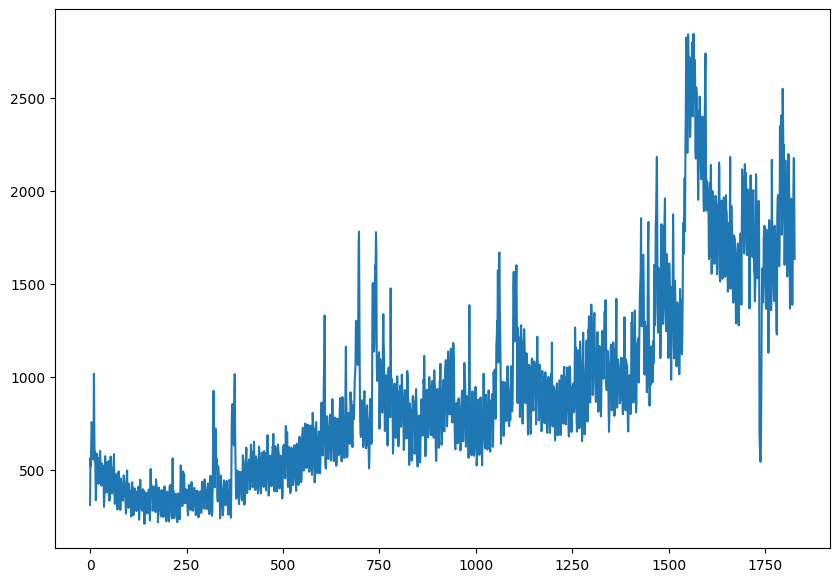

In [6]:
# Plot
data.Udemy.plot(figsize= (10,7))

# Data Prepping / Formatting

In [8]:
# Date Variable: %m/%d/%Y -> %Y-%m-%d
data.Date = pd.to_datetime(data.Date,
                           format="%m/%d/%Y")
data.Date

0      2016-01-01
1      2016-01-02
2      2016-01-03
3      2016-01-04
4      2016-01-05
          ...    
1822   2020-12-27
1823   2020-12-28
1824   2020-12-29
1825   2020-12-30
1826   2020-12-31
Name: Date, Length: 1827, dtype: datetime64[ns]

In [10]:
# Change variable: Date -> ds, time-series (Udemy) -> y
data = data.rename(columns={'Date': 'ds',
                            'Udemy': 'y'})
data.head()

,ds,y,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0
1,2016-01-02,564,0,0,0
2,2016-01-03,517,0,0,0
3,2016-01-04,652,0,0,0
4,2016-01-05,756,0,0,0


# Holidays

In [15]:
# Easter 
easter_dates = data[data.Easter == 1].ds
easter = pd.DataFrame({'holiday': 'easter',
                        'ds': easter_dates,
                        'lower_window': -5,
                        'upper_window': 2})


In [23]:
# Black Friday
bf_dates = data[data['Black Friday'] == 1].ds
bf = pd.DataFrame({'holiday': 'black friday',
                    'ds': bf_dates,
                    'lower_window': -7,
                    'upper_window': 5})


In [24]:
# Combine the holidays
holidays = pd.concat([easter, bf])
holidays

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2
329,black friday,2016-11-25,-7,5
693,black friday,2017-11-24,-7,5
1057,black friday,2018-11-23,-7,5
1428,black friday,2019-11-29,-7,5
1792,black friday,2020-11-27,-7,5


In [25]:
# Remove holidays from main df
data = data.drop(columns=['Easter', 'Black Friday'])
data.head(0)

,ds,y,Christmas


# Prophet Model

In [39]:
# Training and Test Split
test_days = 31
training = data.iloc[:-test_days, : ]
test = data.iloc[-test_days:, : ]
print(test.head(1))
print(training.tail(1))

             ds     y  Christmas
1796 2020-12-01  2393          0
             ds     y  Christmas
1795 2020-11-30  2551          0


In [49]:
# Prophet Model
m = Prophet(growth='linear', 
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            holidays=holidays,
            seasonality_mode='additive',
            seasonality_prior_scale=10,
            holidays_prior_scale=10,
            changepoint_prior_scale=0.05)

m.add_regressor('Christmas', mode='multiplicative')
#m.add_regressor('XXXXXX')

m.fit(training)

21:00:23 - cmdstanpy - INFO - Chain [1] start processing
21:00:23 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
# Regressor Coefficients
from prophet.utilities import regressor_coefficients

regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.0,-0.327334,-0.327334,-0.327334


# Forecasting

In [52]:
# Create future dataframe
future = m.make_future_dataframe(periods = test_days,
                                 freq='D')
future = pd.concat([future, data.iloc[:, 2:]],
                   axis=1)
future.head()

,ds,Christmas
0,2016-01-01,0
1,2016-01-02,0
2,2016-01-03,0
3,2016-01-04,0
4,2016-01-05,0


In [53]:
# Forecasting
forecast = m.predict(future)
forecast.head()
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas', 'Christmas_lower', 'Christmas_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'black friday',
       'black friday_lower', 'black friday_upper', 'easter', 'easter_lower',
       'easter_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'holidays', 'holidays_lower',
       'holidays_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'yhat'],
      dtype='object')


In [58]:
# Holidays assesment
holiday = 'black friday'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][['ds', holiday]]

,ds,black friday
1785,2020-11-20,96.897645
1786,2020-11-21,88.621416
1787,2020-11-22,162.960857
1788,2020-11-23,235.212592
1789,2020-11-24,212.046553
1790,2020-11-25,182.791920
1791,2020-11-26,222.496751
1792,2020-11-27,454.691523
1793,2020-11-28,201.445748
1794,2020-11-29,226.050946


In [61]:
# Retrieve Preds
preds = forecast.yhat[-test_days:]

In [65]:
# Accuracy Assesment
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(test.y, preds))
print(np.sqrt(mean_squared_error(test.y, preds)))

187.70904801888906
239.25492909536305


# Visualization

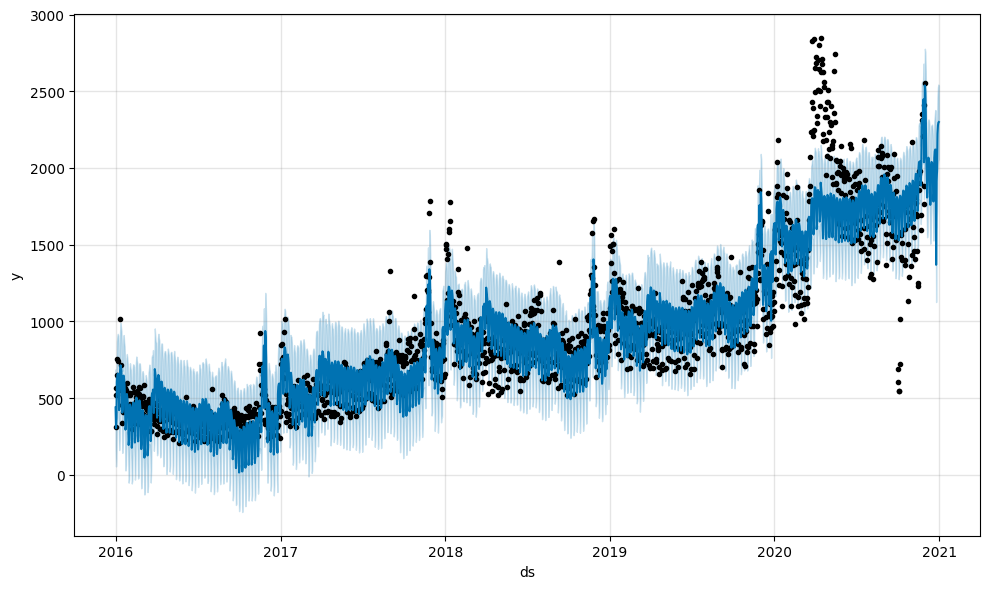

In [67]:
# Visualize the forecast
m.plot(forecast);

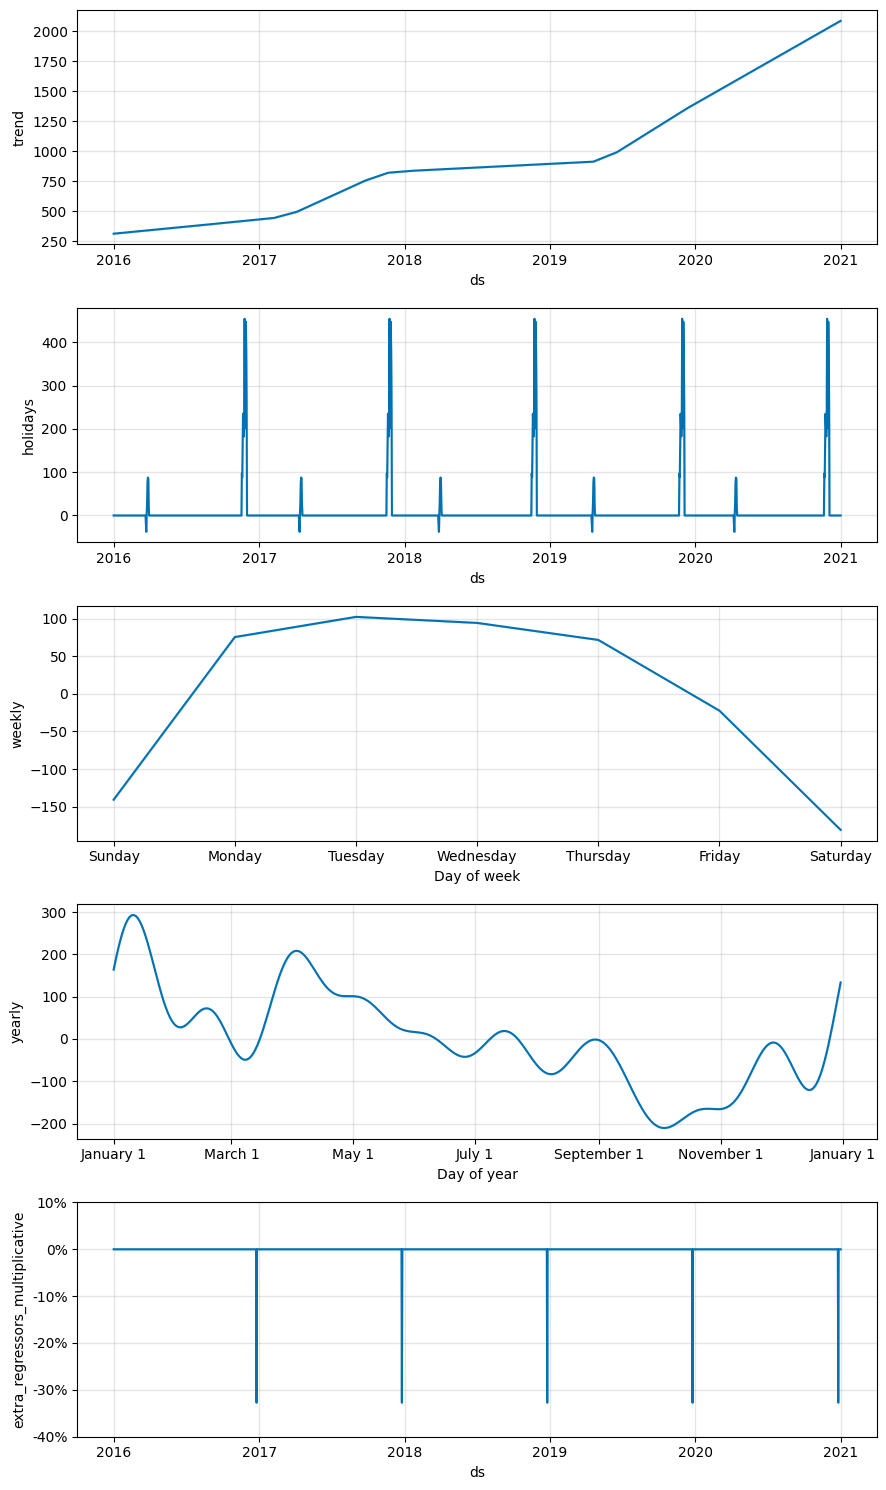

In [68]:
# plot components - > Structural Time Series decomposition
m.plot_components(forecast);

# Cross-Validation

In [70]:
# CV
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, 
                        horizon='31 days', 
                        initial='1450 days', 
                        parallel='processes')

#Output of CV
df_cv.head()



,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-26,1284.240280,1155.249718,1412.808755,1165,2019-12-25
1,2019-12-27,1225.632202,1097.761906,1357.216077,1111,2019-12-25
2,2019-12-28,1104.386975,973.045935,1236.357095,1038,2019-12-25
3,2019-12-29,1166.261368,1033.459174,1304.633584,971,2019-12-25
4,2019-12-30,1374.785926,1241.758027,1510.882891,1192,2019-12-25


In [42]:
len(preds)

31

In [72]:
# Error assesment

print(mean_absolute_error(df_cv['y'], df_cv['yhat']))
print(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])))

400.1652868188919
518.1788783875904


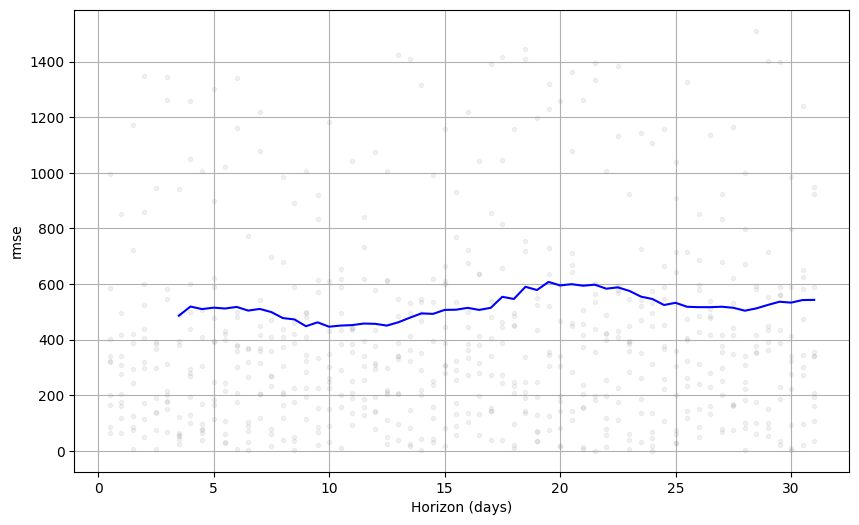

In [74]:
# CV Visualization
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, 
                             metric='rmse');

# Parameter Tuning

In [77]:
# Parameter Grid
from sklearn.model_selection import ParameterGrid

param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
              'seasonality_prior_scale': [5,10,20],
              'holidays_prior_scale': [5,10,20],
              'changepoint_prior_scale': [.01, .05, .1]}

grid = ParameterGrid(param_grid=param_grid)
len(list(grid))

54

In [ ]:
# Empty list to store results
rmse = []

# start the loop
for params in grid:
    # build the model
    m = Prophet(growth='linear',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                holidays=holidays,
                seasonality_mode=params['seasonality_mode'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                holidays_prior_scale=params['holidays_prior_scale'],
                changepoint_prior_scale=params['changepoint_prior_scale']
                )
    m.add_regressor('Christmas')
    m.fit(training)
    
    # cross validation
    df_cv = cross_validation(m, 
                            horizon='31 days', 
                            initial='1450 days', 
                            parallel='processes')


    # measure and store results
    error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))

    rmse.append(error)
    

In [85]:
# Get best parameters
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results.iloc[np.argmin(rmse)]


changepoint_prior_scale               0.1
holidays_prior_scale                   10
seasonality_mode           multiplicative
seasonality_prior_scale                 5
rmse                           449.543619
Name: 45, dtype: object

# Challenge Time - Demand in NYC

## Data Import

In [3]:
df = pd.read_csv('DHS_Daily_Report_2020.csv')
df.head()

,Date,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
0,1/1/2014,50689,0,0,0,2.17
1,1/2/2014,50797,0,0,0,2.51
2,1/3/2014,50954,0,0,0,-6.35
3,1/4/2014,50957,0,0,0,-1.27
4,1/5/2014,50957,0,0,0,7.18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          2557 non-null   object 
 1   Total Individuals in Shelter  2557 non-null   int64  
 2   Easter                        2557 non-null   int64  
 3   Thanksgiving                  2557 non-null   int64  
 4   Christmas                     2557 non-null   int64  
 5   Temperature                   2557 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 120.0+ KB


## Data Prepping

In [5]:
df.Date = pd.to_datetime(df.Date)
df.head()

,Date,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
0,2014-01-01,50689,0,0,0,2.17
1,2014-01-02,50797,0,0,0,2.51
2,2014-01-03,50954,0,0,0,-6.35
3,2014-01-04,50957,0,0,0,-1.27
4,2014-01-05,50957,0,0,0,7.18


In [7]:
df = df.rename(columns={'Date': 'ds', 'Total Individuals in Shelter': 'y'})
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature
0,2014-01-01,50689,0,0,0,2.17
1,2014-01-02,50797,0,0,0,2.51
2,2014-01-03,50954,0,0,0,-6.35
3,2014-01-04,50957,0,0,0,-1.27
4,2014-01-05,50957,0,0,0,7.18


## Holidays

In [12]:
easter_dates = df[df.Easter == 1].ds
easter_dates

easter = pd.DataFrame({'holiday': 'easter',
                        'ds': easter_dates,
                        'lower_window': -5,
                        'upper_window': 2})
easter.head(2)

,holiday,ds,lower_window,upper_window
109,easter,2014-04-20,-5,2
459,easter,2015-04-05,-5,2


In [14]:
tg_dates = df[df.Thanksgiving == 1].ds

tg = pd.DataFrame({'holiday': 'thanksgiving',
                   'ds': tg_dates,
                   'lower_window': -5,
                   'upper_window': 3})
tg.head(2)

,holiday,ds,lower_window,upper_window
330,thanksgiving,2014-11-27,-5,3
694,thanksgiving,2015-11-26,-5,3


In [15]:
chr_dates = df[df.Christmas == 1].ds
christmas = pd.DataFrame({'holiday': 'christmas',
                          'ds': chr_dates,
                          'lower_window': -7,
                          'upper_window': 4})
christmas.head(2)

,holiday,ds,lower_window,upper_window
358,christmas,2014-12-25,-7,4
723,christmas,2015-12-25,-7,4


In [17]:
holidays = pd.concat([easter, tg, christmas])


## Prophet Model

In [19]:
test_days = 31
training = df.iloc[:-test_days, :]
test = df.iloc[-test_days:, :]

print(training.tail(1))
print(test.head(1))

             ds      y  Easter  Thanksgiving  Christmas  Temperature
2525 2020-11-30  53745       0             0          0        16.62
             ds      y  Easter  Thanksgiving  Christmas  Temperature
2526 2020-12-01  53686       0             0          0        13.47


In [20]:
# Build model
m = Prophet(growth='linear',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            holidays=holidays,
            seasonality_mode='additive',
            seasonality_prior_scale=10,
            holidays_prior_scale=10,
            changepoint_prior_scale=.05
            )
m.add_regressor('Temperature', mode='additive')

m.fit(training)

15:52:27 - cmdstanpy - INFO - Chain [1] start processing
15:52:29 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
from prophet.utilities import regressor_coefficients

regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Temperature,additive,14.960234,-10.746884,-10.746884,-10.746884


## Forecasting

In [25]:
# Set up future df
future = m.make_future_dataframe(periods=test_days,
                                 freq='D')
future = pd.concat([future, df.iloc[:, 2:]], axis=1)
future.head()

,ds,Easter,Thanksgiving,Christmas,Temperature
0,2014-01-01,0,0,0,2.17
1,2014-01-02,0,0,0,2.51
2,2014-01-03,0,0,0,-6.35
3,2014-01-04,0,0,0,-1.27
4,2014-01-05,0,0,0,7.18


In [32]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Temperature,Temperature_lower,Temperature_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,49841.834570,50356.515449,51115.884539,49841.834570,49841.834570,137.455152,137.455152,137.455152,889.477760,...,41.293712,41.293712,41.293712,710.728895,710.728895,710.728895,0.0,0.0,0.0,50731.312330
1,2014-01-02,49865.171808,50359.736946,51175.415550,49865.171808,49865.171808,133.801212,133.801212,133.801212,893.916534,...,34.702873,34.702873,34.702873,725.412449,725.412449,725.412449,0.0,0.0,0.0,50759.088341
2,2014-01-03,49888.509046,50437.903316,51209.473197,49888.509046,49888.509046,229.018601,229.018601,229.018601,922.762694,...,-49.929087,-49.929087,-49.929087,743.673180,743.673180,743.673180,0.0,0.0,0.0,50811.271740
3,2014-01-04,49911.846284,50358.449979,51181.535512,49911.846284,49911.846284,174.424432,174.424432,174.424432,848.920195,...,-90.820427,-90.820427,-90.820427,765.316190,765.316190,765.316190,0.0,0.0,0.0,50760.766479
4,2014-01-05,49935.183521,50411.593843,51230.516738,49935.183521,49935.183521,83.613265,83.613265,83.613265,885.287786,...,11.594328,11.594328,11.594328,790.080193,790.080193,790.080193,0.0,0.0,0.0,50820.471308


In [33]:
# Holidays assesment
holiday = 'thanksgiving'
forecast[(forecast[holiday].abs() > 0) & (forecast.ds > '2020-01-01')][['ds', holiday]]

,ds,thanksgiving
2516,2020-11-21,32.704839
2517,2020-11-22,-39.365480
2518,2020-11-23,-25.987143
2519,2020-11-24,-20.430744
2520,2020-11-25,-99.791391
2521,2020-11-26,-180.917535
2522,2020-11-27,-120.578526
2523,2020-11-28,-110.499096
2524,2020-11-29,-216.246514


In [34]:
# Grab preds
preds = forecast.yhat[-test_days:]


In [35]:
# Accuracy Assesment
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(test.y, preds))
print(np.sqrt(mean_squared_error(test.y, preds)))

1432.2531702075444
1438.6608056558425


## Visualization

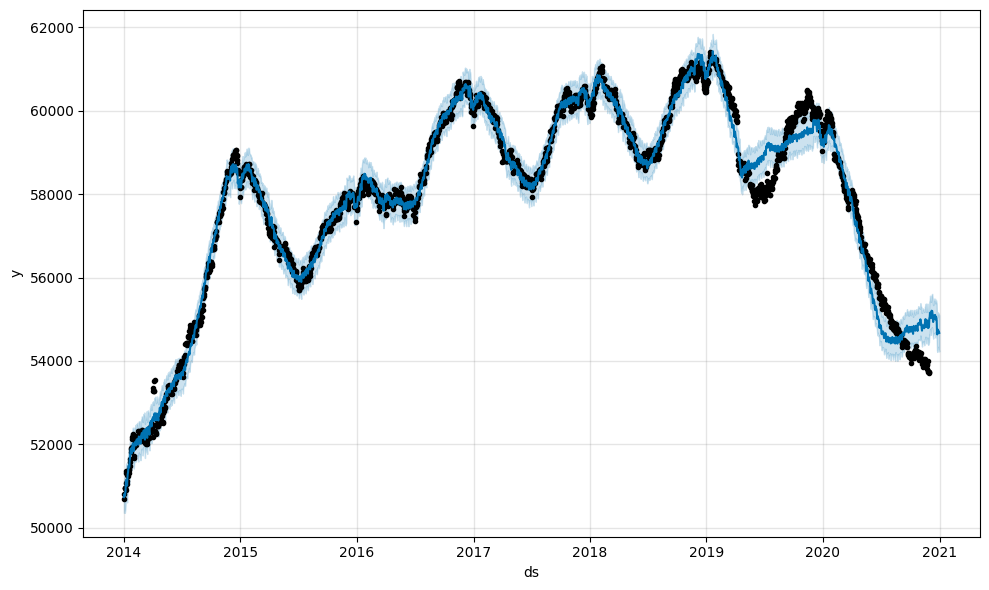

In [37]:
m.plot(forecast);

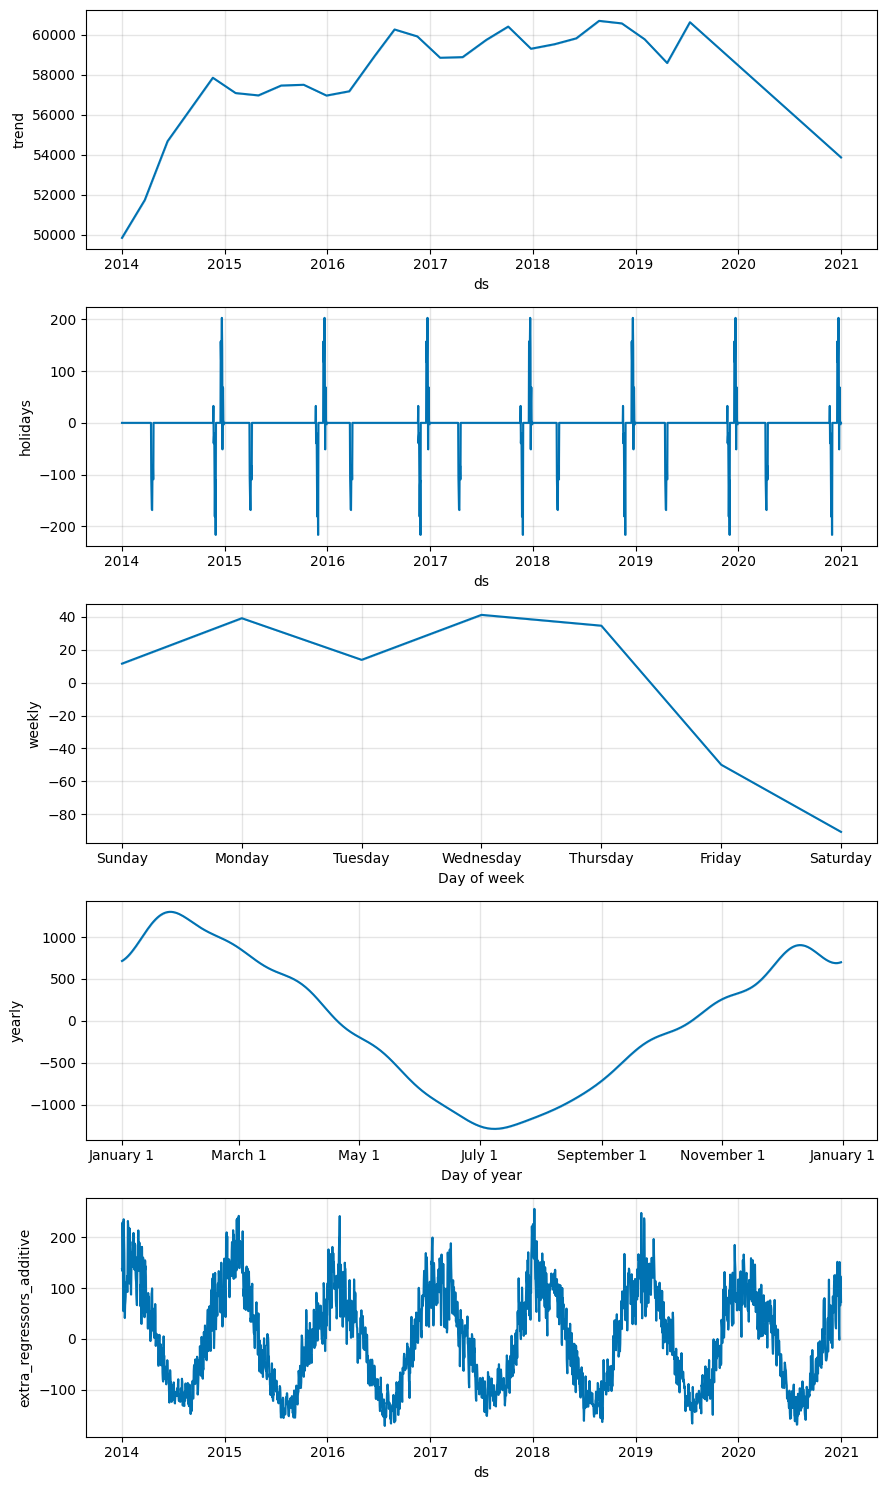

In [39]:
m.plot_components(forecast);

## Cross Validation

In [46]:
training.shape

(2526, 6)

In [48]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m, horizon='31 days', initial='2160 days', parallel='processes')
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-10,60241.840212,60036.408568,60449.642343,59979,2019-12-09 12:00:00
1,2019-12-11,60315.352383,60105.485645,60521.501347,60000,2019-12-09 12:00:00
2,2019-12-12,60309.043722,60092.648357,60516.856091,60039,2019-12-09 12:00:00
3,2019-12-13,60147.167138,59937.778482,60353.932336,59911,2019-12-09 12:00:00
4,2019-12-14,60069.757782,59861.165096,60271.076217,59860,2019-12-09 12:00:00


In [50]:
# CV Assesment
print(mean_absolute_error(df_cv['y'], df_cv['yhat']))
print(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])))

990.7142272710545
1279.7153747286022


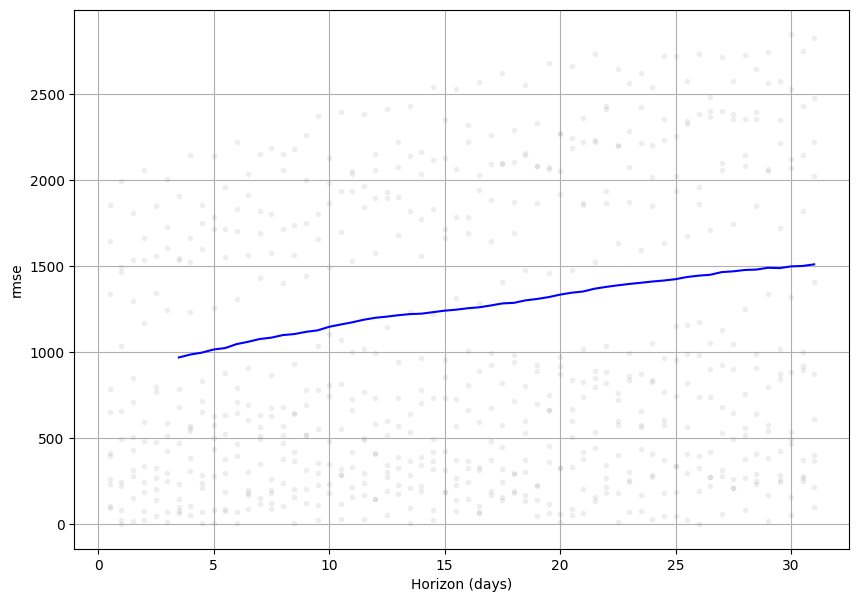

In [53]:
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv=df_cv, metric='rmse', figsize=(10,7));

## Parameter Tuning 

In [55]:
# Parameter grid
from sklearn.model_selection import ParameterGrid

grid = {'seasonality_mode': ['additive', 'multiplicative'],
        'seasonality_prior_scale': [5,10,15,20],
        'holidays_prior_scale': [5,10,15,20],
        'changepoint_prior_scale': [.001, .01, .05, .1]}

params = ParameterGrid(grid)



In [56]:
# Store error
rmse = []

# For loop
for param in params:
    # build model
    
    m = Prophet(growth='linear',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                holidays=holidays,
                seasonality_mode=param['seasonality_mode'],
                seasonality_prior_scale=param['seasonality_prior_scale'],
                holidays_prior_scale=param['holidays_prior_scale'],
                changepoint_prior_scale=param['changepoint_prior_scale']
                )
    m.add_regressor('Temperature', mode='multiplicative')
    m.fit(training)

     # cross validation
    df_cv = cross_validation(m, 
                            horizon='31 days', 
                            initial='2160 days', 
                            parallel='processes')


    # measure and store results
    error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))

    rmse.append(error)

    

16:32:12 - cmdstanpy - INFO - Chain [1] start processing
16:32:12 - cmdstanpy - INFO - Chain [1] done processing
16:32:29 - cmdstanpy - INFO - Chain [1] start processing
16:32:30 - cmdstanpy - INFO - Chain [1] done processing
16:32:45 - cmdstanpy - INFO - Chain [1] start processing
16:32:46 - cmdstanpy - INFO - Chain [1] done processing
16:33:00 - cmdstanpy - INFO - Chain [1] start processing
16:33:01 - cmdstanpy - INFO - Chain [1] done processing
16:33:17 - cmdstanpy - INFO - Chain [1] start processing
16:33:17 - cmdstanpy - INFO - Chain [1] done processing
16:33:33 - cmdstanpy - INFO - Chain [1] start processing
16:33:34 - cmdstanpy - INFO - Chain [1] done processing
16:33:50 - cmdstanpy - INFO - Chain [1] start processing
16:33:50 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:21 - cmdstanpy - INFO - Chain [1] start processing
16:34:22 - cmdstanpy - INFO - Chain [1]

In [59]:
len(grid)

4

In [60]:
# Get best parameters
tuning_results = pd.DataFrame(params)
tuning_results['rmse'] = rmse
tuning_results.iloc[np.argmin(rmse)]


changepoint_prior_scale               0.1
holidays_prior_scale                   15
seasonality_mode           multiplicative
seasonality_prior_scale                15
rmse                          1247.735214
Name: 118, dtype: object